### Introduction

This project presents a comprehensive data driven analysis of medical insurance, expenses and premiums, with a focus on uncovering the demographic and behavioural factors that inference healthcare costs.

The data set is used in the study includes detailed records of policyholders, capturing both demographic attributes (such as age, gender, BMI, number of children) and financial metrics (such as medical expenses and insurance premiums). By leveraging statistical modeling and machine learning techniques, I aim to build predictive models that estimate medical costs and premiums with high accuracy.

**About Dataset**

| Feature               | Description                                                                                  |
|-----------------------|----------------------------------------------------------------------------------------------|
| **age**               | Age of the policyholder                                                                      |
| **gender**            | Gender of the policyholder (`m` for male, `f` for female)                                    |
| **bmi**               | Body Mass Index of the policyholder                                                          |
| **children**          | Number of children covered by the insurance policy                                           |
| **discount eligibility** | Indicates whether the policyholder is eligible for a discount (`y` for yes, `n` for no)   |
| **region**            | Geographic region where the policyholder resides (e.g., southeast, northwest)                |
| **expenses**          | Actual medical costs incurred by the policyholder                                            |
| **premium**           | Insurance premium charged to the policyholder                                                |


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
from sklearn.metrics import (
accuracy_score, roc_auc_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
)

from sklearn.model_selection import (train_test_split, cross_validate, GridSearchCV, KFold, cross_val_score)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

custom_palette = ["#B7D5D4", "#77878B", "#488286", "#305252"]
sns.set_palette(sns.color_palette(custom_palette))

In [4]:
data = pd.read_csv('/Users/simarmalhan/Downloads/medical_insurance.csv')
data = pd.DataFrame(data)
data

,age,gender,bmi,children,discount_eligibility,region,expenses,premium
0,19,female,27.900,0,yes,southwest,16884.920,168.849
1,18,male,33.800,1,no,southeast,1725.550,17.256
2,28,male,33.000,3,no,southeast,4449.460,44.495
3,33,male,22.700,0,no,northwest,21984.470,439.689
4,32,male,28.900,0,no,northwest,3866.860,77.337
...,...,...,...,...,...,...,...,...
1333,50,male,31.000,3,no,northwest,10600.550,212.011
1334,18,female,31.900,0,no,northeast,2205.980,22.060
1335,18,female,36.900,0,no,southeast,1629.830,16.298
1336,21,female,25.800,0,no,southwest,2007.950,20.079


In [5]:
data.columns

Index(['age', 'gender', 'bmi', 'children', 'discount_eligibility', 'region', 'expenses', 'premium'], dtype='object')

In [6]:
data.shape

(1338, 8)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1338 non-null   int64  
 1   gender                1338 non-null   object 
 2   bmi                   1338 non-null   float64
 3   children              1338 non-null   int64  
 4   discount_eligibility  1338 non-null   object 
 5   region                1338 non-null   object 
 6   expenses              1338 non-null   float64
 7   premium               1338 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 83.8+ KB


In [8]:
print('Number of duplicated rows: ', len(data[data.duplicated()]))

Number of duplicated rows:  1


In [9]:
data = data.drop_duplicates().reset_index(drop = True)

In [10]:
styled = data.describe().T.style.background_gradient(cmap = 'plasma', axis = 1)
styled

,count,mean,std,min,25%,50%,75%,max
age,1337.000000,39.222139,14.044333,18.000000,27.000000,39.000000,51.000000,64.000000
bmi,1337.000000,30.665520,6.100664,16.000000,26.300000,30.400000,34.700000,53.100000
children,1337.000000,1.095737,1.205571,0.000000,0.000000,1.000000,2.000000,5.000000
expenses,1337.000000,13279.121638,12110.359657,1121.870000,4746.340000,9386.160000,16657.720000,63770.430000
premium,1337.000000,263.059038,292.563876,11.218700,87.994600,175.305000,343.031700,1983.106400


In [11]:
unique_counts = data.nunique()
print(unique_counts)

age                       47
gender                     2
bmi                      275
children                   6
discount_eligibility       2
region                     4
expenses                1337
premium                 1337
dtype: int64


In [12]:
# generate the profile report

profile = ProfileReport(data,
                       title = 'Dataset Report',
                       minimal = True,
                       progress_bar = False,
                        samples = None,
                        correlations = None,
                        interactions = None,
                        explorative = True
                       )

# display the notebook as an iframe in the notebook

profile.to_notebook_iframe()

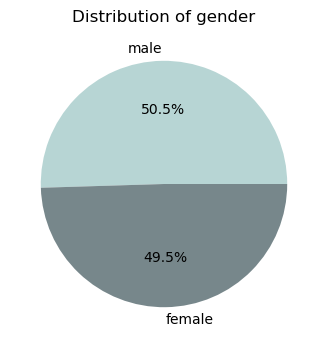

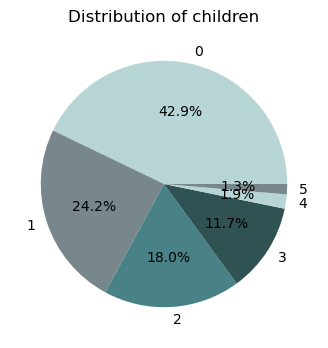

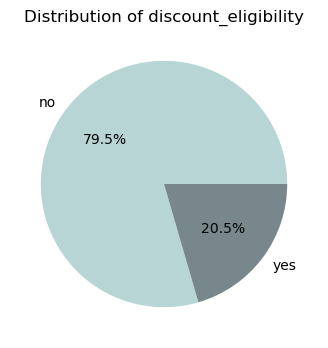

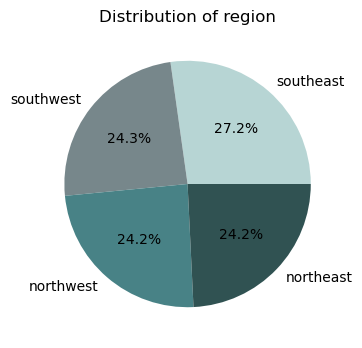

In [13]:
columns = ['gender', 'children', 'discount_eligibility', 'region']
for column in columns:
    data[column].value_counts().plot.pie(
        autopct = '%1.1f%%',
        figsize = (4, 4),
        title = f'Distribution of {column}'
    )
    plt.ylabel('')
    plt.show()

In [14]:
# dropping non-numerical data

hm = data.drop(columns=['discount_eligibility', 'gender', 'region'])

In [24]:
styled_corr = hm.corr(numeric_only = True).T.style.background_gradient(cmap = 'viridis', axis = 1)
styled_corr

,age,bmi,children,expenses,premium
age,1.000000,0.109414,0.041536,0.298308,0.529971
bmi,0.109414,1.000000,0.012641,0.198637,0.177928
children,0.041536,0.012641,1.000000,0.067389,0.041868
expenses,0.298308,0.198637,0.067389,1.000000,0.853921
premium,0.529971,0.177928,0.041868,0.853921,1.000000


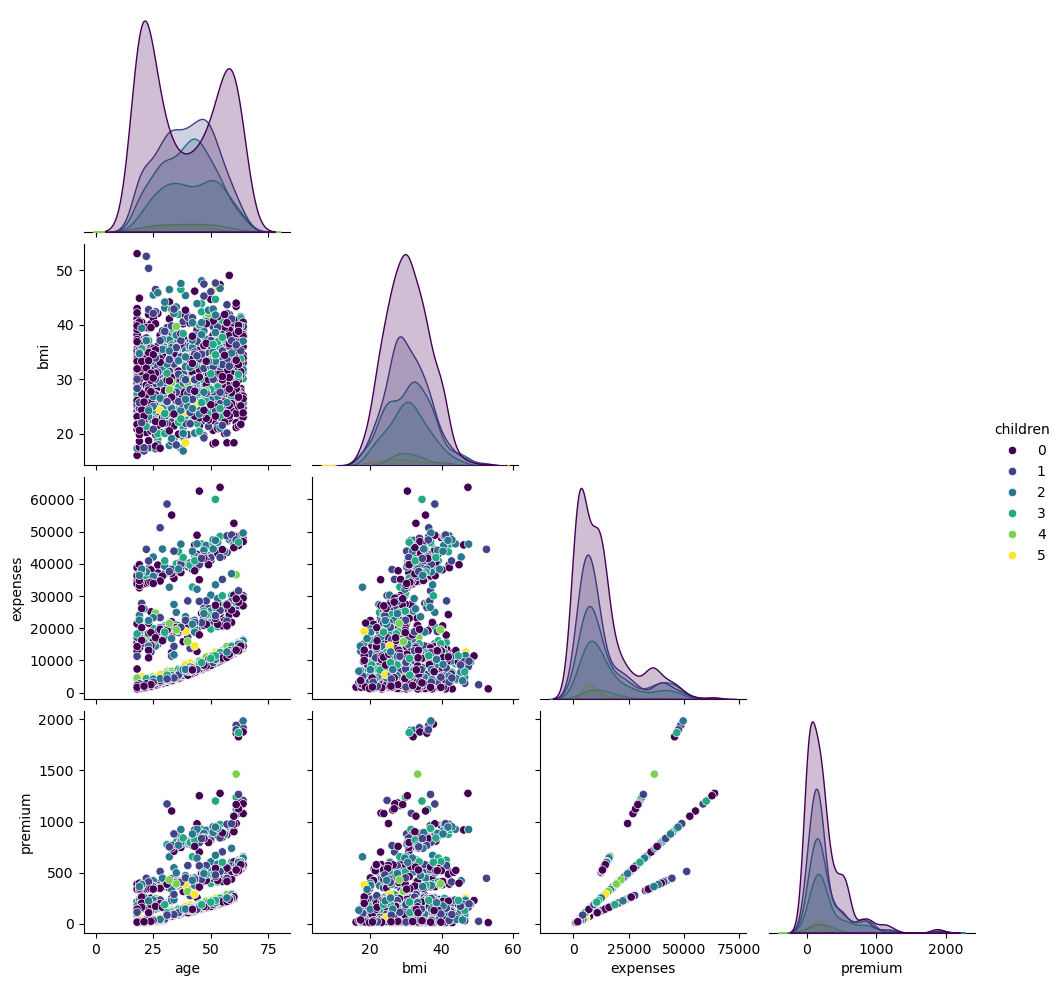

In [25]:
sns.pairplot(
    data = hm,
    diag_kind = 'kde',
    hue = 'children',
    palette = 'viridis',
    corner = True
)
plt.show()

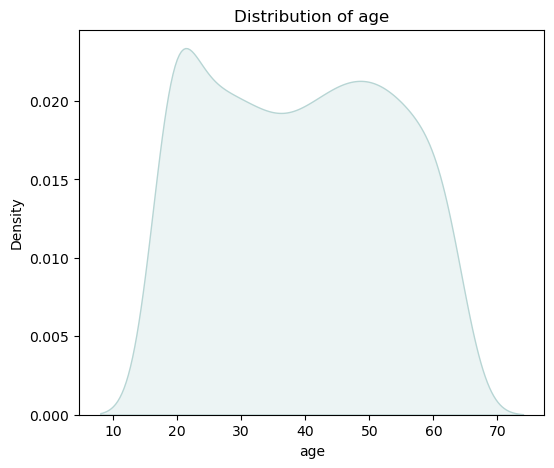

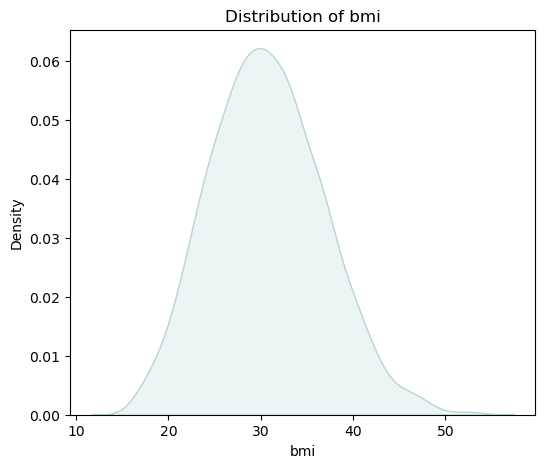

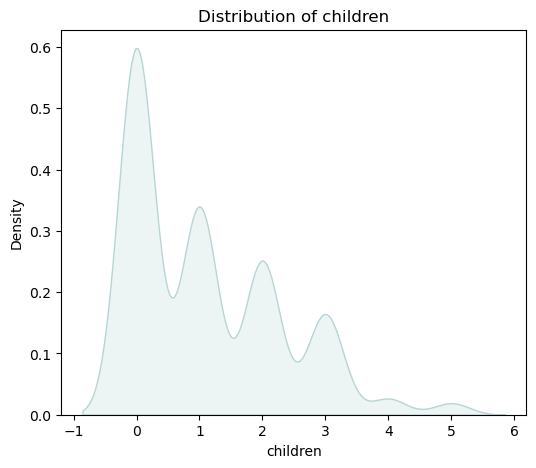

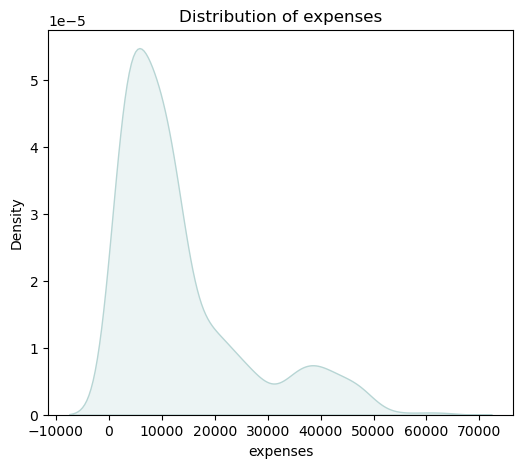

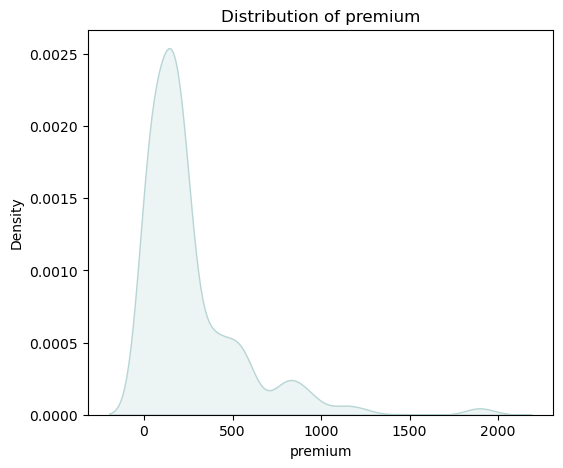

In [26]:
# kde plots

for column in data.columns:
    if data[column].dtype in ['int64', 'float64']:
        plt.figure(figsize = (6, 5))
        sns.kdeplot(data = data, x = column, fill = True)
        plt.xlabel(column)
        plt.ylabel('Density')
        plt.title(f'Distribution of {column}')
        plt.show()

In [27]:
# skewness of numeric columns

numeric_columns = data.select_dtypes(include = ['number']).columns
skew_values = data[numeric_columns].skew(axis = 0, skipna = True)

print('Skewness of Numeric Columns: \n')
print(skew_values.sort_values(ascending = False).round(3))

Skewness of Numeric Columns: 

premium    2.522
expenses   1.515
children   0.937
bmi        0.284
age        0.055
dtype: float64


- Skewness < 0.5: fairly symmetrical  
- 0.5 ≤ skewness < 1: moderately skewed  
- Skewness ≥ 1: highly skewed

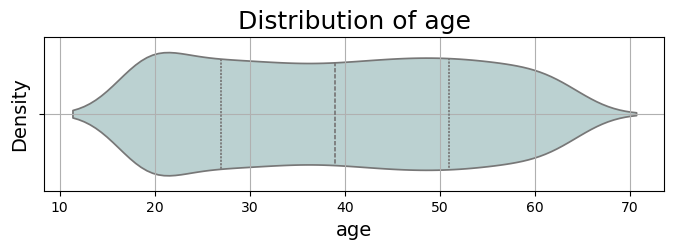

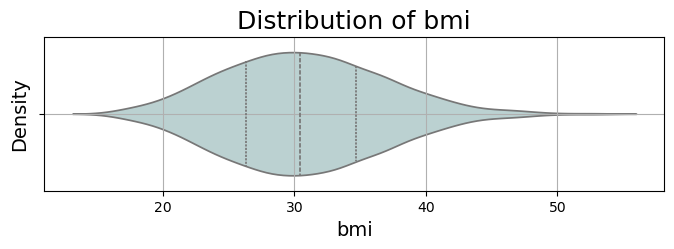

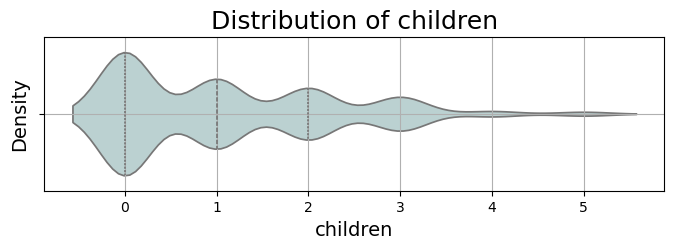

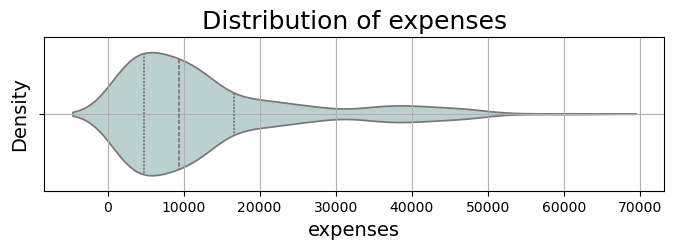

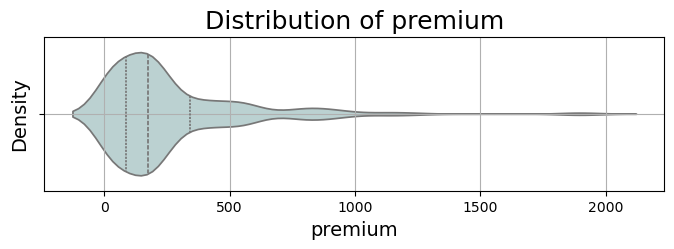

In [30]:
# violin plots

for column in data.select_dtypes(include = ['number']).columns:
    plt.figure(figsize = (8, 2))
    sns.violinplot(
    x = data[column],
    inner = 'quartile'
    )
    plt.title(f'Distribution of {column}', fontsize = 18)
    plt.xlabel(column, fontsize = 14)
    plt.ylabel('Density', fontsize = 14)
    plt.grid(True)
    plt.show()

In [38]:
data_out = data.copy()
data_out = pd.get_dummies(
    data_out,
    columns = ['gender', 'discount_eligibility', 'region'],
    dtype = int,
    drop_first = {'gender': True, 'discount_eligibility': True, 'region': False}
)

In [40]:
data_out.head()

,age,bmi,children,expenses,premium,gender_male,discount_eligibility_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.920,168.849,0,1,0,0,1
1,18,33.800,1,1725.550,17.256,1,0,0,1,0
2,28,33.000,3,4449.460,44.495,1,0,0,1,0
3,33,22.700,0,21984.470,439.689,1,0,1,0,0
4,32,28.900,0,3866.860,77.337,1,0,1,0,0


In [52]:
features = data_out.drop(columns = ['expenses'])
target = data_out['expenses']

In [54]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

model_candidates = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Regressor': SVR()
}

results = []

for name, model in model_candidates.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MSE': mse, 'R2': r2})

results_df = pd.DataFrame(results).sort_values('R2', ascending = False)
print(results_df)

                      Model           MSE     R2
6         Gradient Boosting   1561358.209  0.992
5             Random Forest   1830147.930  0.990
4             Decision Tree   2448706.581  0.987
7                  AdaBoost   9274796.616  0.950
8       K-Nearest Neighbors  11074296.942  0.940
0         Linear Regression  20154263.549  0.890
2          Lasso Regression  20162672.254  0.890
1          Ridge Regression  20212937.606  0.890
3                ElasticNet  32601595.599  0.823
9  Support Vector Regressor 205032817.259 -0.116


In [50]:
# Fit Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

# Fit Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_preds)
gb_r2 = r2_score(y_test, gb_preds)

print('Random Forest - MSE:', rf_mse, ', R2:', rf_r2)
print('Gradient Boosting - MSE:', gb_mse, ', R2:', gb_r2)

Random Forest - MSE: 1868222.309516881 , R2: 0.9898331395269843
Gradient Boosting - MSE: 1520123.8588946506 , R2: 0.9917274903011511


In [56]:
# feature importance

def get_feature_importance(model, feature_names):
    return pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending = False)

rf_importances = get_feature_importance(rf_model, X_train.columns)
gb_importances = get_feature_importance(gb_model, X_train.columns)

In [60]:
print("Random Forest - Top Features:")
print(rf_importances.head(3))

print("\nGradient Boosting - Top Features:")
print(gb_importances.head(3))

Random Forest - Top Features:
premium                    0.830
age                        0.107
discount_eligibility_yes   0.040
dtype: float64

Gradient Boosting - Top Features:
premium                    0.823
age                        0.106
discount_eligibility_yes   0.040
dtype: float64


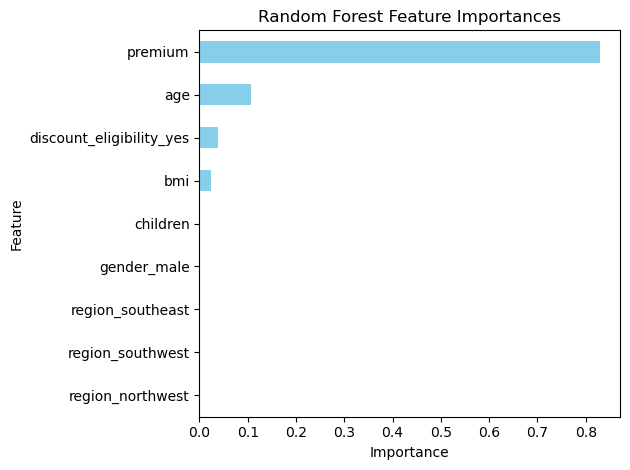

In [62]:
rf_importances.head(10).plot(kind='barh', color='skyblue')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

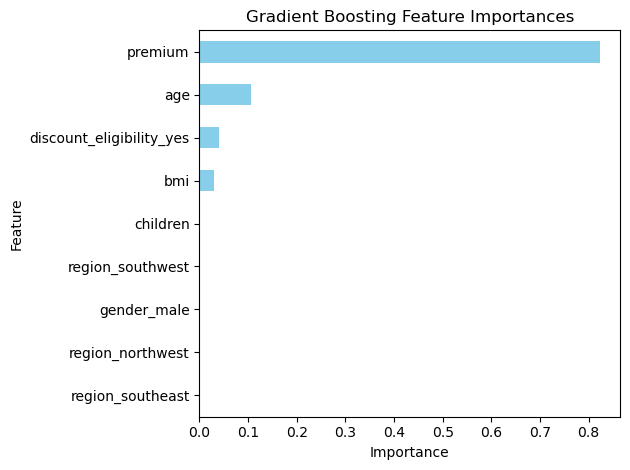

In [64]:
gb_importances.head(10).plot(kind='barh', color='skyblue')
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()